# SED plots
Here we present the galaxy with the best SED in the models presented by Stalevski et. al 2012, 2016 [(SKIRTOR)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.458.2288S/abstract) and Fritz et. al 2006 [(Fritz)](https://ui.adsabs.harvard.edu/abs/2006MNRAS.366..767F/abstract).

First, we import all important packages.

In [1]:
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.table import Table, join
import astropy.units as u

We then read the photometry and the clean outputs from CIGALE

In [3]:
Phot = Table.read('../Data/Final/CIGPhot_EnergyBal_All.tbl', format='ascii')

In [4]:
ModelS = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_SK.fits', format='fits')
ModelF = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_Fr.fits', format='fits')

We count the number of photometry points for the SED fitting for each galaxy and join with the previous Tables.

In [5]:
Phot['CountPoints'] = [sum(~np.isnan(list(j))) /
                       2 for j in Phot[Phot.colnames[2:]].as_array()]
PhotS = join(Phot, ModelS)
PhotF = join(Phot, ModelF)

Finally, we join both tables into one to select only galaxies where we have satisfiying results in both models

In [6]:
PhotAll = join(PhotS, PhotF, keys=('id','redshift','CountPoints'), table_names=['S', 'F'])

## Select best and worst SED fittings

For the best galaxy, we select galaxies with more than 20 photometry points and $\chi_{\rm{red}}^{2}$ values close to 1.

In [7]:
AllS_chis = PhotAll['best.reduced_chi_square_S']
AllF_chis = PhotAll['best.reduced_chi_square_F']

SelecCut = np.logical_and.reduce([AllS_chis < 1.2, AllF_chis < 1.2,
                                  AllS_chis > 0.8, AllF_chis > 0.8,
                                  PhotAll['CountPoints'] >= 20])

In [8]:
PhotAll[SelecCut]

id,redshift,FUV_S,FUV_err_S,NUV_S,NUV_err_S,u_prime_S,u_prime_err_S,g_prime_S,g_prime_err_S,r_prime_S,r_prime_err_S,i_prime_S,i_prime_err_S,z_prime_S,z_prime_err_S,J_2mass_S,J_2mass_err_S,H_2mass_S,H_2mass_err_S,Ks_2mass_S,Ks_2mass_err_S,WISE1_S,WISE1_err_S,IRAC1_S,IRAC1_err_S,IRAC2_S,IRAC2_err_S,WISE2_S,WISE2_err_S,IRAC3_S,IRAC3_err_S,IRAC4_S,IRAC4_err_S,IRAS1_S,IRAS1_err_S,WISE3_S,WISE3_err_S,WISE4_S,WISE4_err_S,MIPS1_S,MIPS1_err_S,IRAS2_S,IRAS2_err_S,IRAS3_S,IRAS3_err_S,PACS_blue_S,PACS_blue_err_S,MIPS2_S,MIPS2_err_S,IRAS4_S,IRAS4_err_S,PACS_green_S,PACS_green_err_S,MIPS3_S,MIPS3_err_S,PACS_red_S,PACS_red_err_S,PSW_ext_S,PSW_ext_err_S,PMW_ext_S,PMW_ext_err_S,PLW_ext_S,PLW_ext_err_S,CountPoints,bayes.agn.EBV_S,bayes.agn.EBV_err_S,bayes.agn.Mcl,bayes.agn.Mcl_err,bayes.agn.R,bayes.agn.R_err,bayes.agn.emissivity_S,bayes.agn.emissivity_err_S,bayes.agn.fracAGN_S,bayes.agn.fracAGN_err_S,bayes.agn.fracAGN_dale2014_S,bayes.agn.fracAGN_dale2014_err_S,bayes.agn.i_S,bayes.agn.i_err_S,bayes.agn.law_S,bayes.agn.law_err_S,bayes.agn.oa,bayes.agn.oa_err,bayes.agn.pl,bayes.agn.pl_err,bayes.agn.q,bayes.agn.q_err,bayes.agn.t,bayes.agn.t_err,bayes.agn.temperature_S,bayes.agn.temperature_err_S,bayes.attenuation.E_BV_factor_S,bayes.attenuation.E_BV_factor_err_S,bayes.attenuation.E_BV_lines_S,bayes.attenuation.E_BV_lines_err_S,bayes.attenuation.E_BVs_S,bayes.attenuation.E_BVs_err_S,bayes.attenuation.FUV_S,bayes.attenuation.FUV_err_S,bayes.attenuation.powerlaw_slope_S,bayes.attenuation.powerlaw_slope_err_S,bayes.attenuation.uv_bump_amplitude_S,bayes.attenuation.uv_bump_amplitude_err_S,bayes.attenuation.uv_bump_wavelength_S,bayes.attenuation.uv_bump_wavelength_err_S,bayes.attenuation.uv_bump_width_S,bayes.attenuation.uv_bump_width_err_S,bayes.dust.alpha_S,bayes.dust.alpha_err_S,bayes.nebular.f_dust_S,bayes.nebular.f_dust_err_S,bayes.nebular.f_esc_S,bayes.nebular.f_esc_err_S,bayes.nebular.lines_width_S,bayes.nebular.lines_width_err_S,bayes.nebular.logU_S,bayes.nebular.logU_err_S,bayes.sfh.age_S,bayes.sfh.age_err_S,bayes.sfh.age_burst_S,bayes.sfh.age_burst_err_S,bayes.sfh.age_main_S,bayes.sfh.age_main_err_S,bayes.sfh.f_burst_S,bayes.sfh.f_burst_err_S,bayes.sfh.tau_burst_S,bayes.sfh.tau_burst_err_S,bayes.sfh.tau_main_S,bayes.sfh.tau_main_err_S,bayes.stellar.age_m_star_S,bayes.stellar.age_m_star_err_S,bayes.stellar.imf_S,bayes.stellar.imf_err_S,bayes.stellar.metallicity_S,bayes.stellar.metallicity_err_S,bayes.stellar.old_young_separation_age_S,bayes.stellar.old_young_separation_age_err_S,bayes.universe.age_S,bayes.universe.age_err_S,bayes.universe.luminosity_distance_S,bayes.universe.luminosity_distance_err_S,bayes.universe.redshift_S,bayes.universe.redshift_err_S,bayes.agn.accretion_power_S,bayes.agn.accretion_power_err_S,bayes.agn.disk_luminosity_S,bayes.agn.disk_luminosity_err_S,bayes.agn.dust_luminosity_S,bayes.agn.dust_luminosity_err_S,bayes.agn.intrin_Lnu_2500A_S,bayes.agn.intrin_Lnu_2500A_err_S,bayes.agn.luminosity_S,bayes.agn.luminosity_err_S,bayes.dust.luminosity_S,bayes.dust.luminosity_err_S,bayes.sfh.integrated_S,bayes.sfh.integrated_err_S,bayes.sfh.sfr_S,bayes.sfh.sfr_err_S,bayes.sfh.sfr100Myrs_S,bayes.sfh.sfr100Myrs_err_S,bayes.sfh.sfr10Myrs_S,bayes.sfh.sfr10Myrs_err_S,bayes.stellar.lum_S,bayes.stellar.lum_err_S,bayes.stellar.lum_ly_S,bayes.stellar.lum_ly_err_S,bayes.stellar.lum_ly_old_S,bayes.stellar.lum_ly_old_err_S,bayes.stellar.lum_ly_young_S,bayes.stellar.lum_ly_young_err_S,bayes.stellar.lum_old_S,bayes.stellar.lum_old_err_S,bayes.stellar.lum_young_S,bayes.stellar.lum_young_err_S,bayes.stellar.m_gas_S,bayes.stellar.m_gas_err_S,bayes.stellar.m_gas_old_S,bayes.stellar.m_gas_old_err_S,bayes.stellar.m_gas_young_S,bayes.stellar.m_gas_young_err_S,bayes.stellar.m_star_S,bayes.stellar.m_star_err_S,bayes.stellar.m_star_old_S,bayes.stellar.m_star_old_err_S,bayes.stellar.m_star_young_S,bayes.stellar.m_star_young_err_S,bayes.stellar.n_ly_S,bayes.stellar.n_ly_err_S,bayes.stellar.n_ly_old_S,bayes.stellar.n_ly_old_err_S,bayes.stellar.n_ly_young_S,bay

We select 2MASX J13320532+3127360 galaxy as the best SED fitting (Due to its $\chi_{\rm{red}}^{2}$ values).

In [9]:
SelectedGalaxy = '2MASX J13320532+3127360'

For the worst galaxy, we select a galaxy with a $\chi_{\rm{red}}^{2}$ close to our selected limits in the $\chi_{\rm{red}}^{2}$ distribution (See FIGURE 2), with less or equal to 9 photometry points

In [10]:
WorstCut = np.logical_and.reduce([np.logical_xor(AllS_chis < 10**(0.49),
                                                 AllS_chis > 10**(-0.49)),
                                  np.logical_xor(AllF_chis < 10**(0.49),
                                                 AllF_chis > 10**(-0.49)),
                                  PhotAll['CountPoints'] <= 9])

In [11]:
PhotAll[WorstCut]

id,redshift,FUV_S,FUV_err_S,NUV_S,NUV_err_S,u_prime_S,u_prime_err_S,g_prime_S,g_prime_err_S,r_prime_S,r_prime_err_S,i_prime_S,i_prime_err_S,z_prime_S,z_prime_err_S,J_2mass_S,J_2mass_err_S,H_2mass_S,H_2mass_err_S,Ks_2mass_S,Ks_2mass_err_S,WISE1_S,WISE1_err_S,IRAC1_S,IRAC1_err_S,IRAC2_S,IRAC2_err_S,WISE2_S,WISE2_err_S,IRAC3_S,IRAC3_err_S,IRAC4_S,IRAC4_err_S,IRAS1_S,IRAS1_err_S,WISE3_S,WISE3_err_S,WISE4_S,WISE4_err_S,MIPS1_S,MIPS1_err_S,IRAS2_S,IRAS2_err_S,IRAS3_S,IRAS3_err_S,PACS_blue_S,PACS_blue_err_S,MIPS2_S,MIPS2_err_S,IRAS4_S,IRAS4_err_S,PACS_green_S,PACS_green_err_S,MIPS3_S,MIPS3_err_S,PACS_red_S,PACS_red_err_S,PSW_ext_S,PSW_ext_err_S,PMW_ext_S,PMW_ext_err_S,PLW_ext_S,PLW_ext_err_S,CountPoints,bayes.agn.EBV_S,bayes.agn.EBV_err_S,bayes.agn.Mcl,bayes.agn.Mcl_err,bayes.agn.R,bayes.agn.R_err,bayes.agn.emissivity_S,bayes.agn.emissivity_err_S,bayes.agn.fracAGN_S,bayes.agn.fracAGN_err_S,bayes.agn.fracAGN_dale2014_S,bayes.agn.fracAGN_dale2014_err_S,bayes.agn.i_S,bayes.agn.i_err_S,bayes.agn.law_S,bayes.agn.law_err_S,bayes.agn.oa,bayes.agn.oa_err,bayes.agn.pl,bayes.agn.pl_err,bayes.agn.q,bayes.agn.q_err,bayes.agn.t,bayes.agn.t_err,bayes.agn.temperature_S,bayes.agn.temperature_err_S,bayes.attenuation.E_BV_factor_S,bayes.attenuation.E_BV_factor_err_S,bayes.attenuation.E_BV_lines_S,bayes.attenuation.E_BV_lines_err_S,bayes.attenuation.E_BVs_S,bayes.attenuation.E_BVs_err_S,bayes.attenuation.FUV_S,bayes.attenuation.FUV_err_S,bayes.attenuation.powerlaw_slope_S,bayes.attenuation.powerlaw_slope_err_S,bayes.attenuation.uv_bump_amplitude_S,bayes.attenuation.uv_bump_amplitude_err_S,bayes.attenuation.uv_bump_wavelength_S,bayes.attenuation.uv_bump_wavelength_err_S,bayes.attenuation.uv_bump_width_S,bayes.attenuation.uv_bump_width_err_S,bayes.dust.alpha_S,bayes.dust.alpha_err_S,bayes.nebular.f_dust_S,bayes.nebular.f_dust_err_S,bayes.nebular.f_esc_S,bayes.nebular.f_esc_err_S,bayes.nebular.lines_width_S,bayes.nebular.lines_width_err_S,bayes.nebular.logU_S,bayes.nebular.logU_err_S,bayes.sfh.age_S,bayes.sfh.age_err_S,bayes.sfh.age_burst_S,bayes.sfh.age_burst_err_S,bayes.sfh.age_main_S,bayes.sfh.age_main_err_S,bayes.sfh.f_burst_S,bayes.sfh.f_burst_err_S,bayes.sfh.tau_burst_S,bayes.sfh.tau_burst_err_S,bayes.sfh.tau_main_S,bayes.sfh.tau_main_err_S,bayes.stellar.age_m_star_S,bayes.stellar.age_m_star_err_S,bayes.stellar.imf_S,bayes.stellar.imf_err_S,bayes.stellar.metallicity_S,bayes.stellar.metallicity_err_S,bayes.stellar.old_young_separation_age_S,bayes.stellar.old_young_separation_age_err_S,bayes.universe.age_S,bayes.universe.age_err_S,bayes.universe.luminosity_distance_S,bayes.universe.luminosity_distance_err_S,bayes.universe.redshift_S,bayes.universe.redshift_err_S,bayes.agn.accretion_power_S,bayes.agn.accretion_power_err_S,bayes.agn.disk_luminosity_S,bayes.agn.disk_luminosity_err_S,bayes.agn.dust_luminosity_S,bayes.agn.dust_luminosity_err_S,bayes.agn.intrin_Lnu_2500A_S,bayes.agn.intrin_Lnu_2500A_err_S,bayes.agn.luminosity_S,bayes.agn.luminosity_err_S,bayes.dust.luminosity_S,bayes.dust.luminosity_err_S,bayes.sfh.integrated_S,bayes.sfh.integrated_err_S,bayes.sfh.sfr_S,bayes.sfh.sfr_err_S,bayes.sfh.sfr100Myrs_S,bayes.sfh.sfr100Myrs_err_S,bayes.sfh.sfr10Myrs_S,bayes.sfh.sfr10Myrs_err_S,bayes.stellar.lum_S,bayes.stellar.lum_err_S,bayes.stellar.lum_ly_S,bayes.stellar.lum_ly_err_S,bayes.stellar.lum_ly_old_S,bayes.stellar.lum_ly_old_err_S,bayes.stellar.lum_ly_young_S,bayes.stellar.lum_ly_young_err_S,bayes.stellar.lum_old_S,bayes.stellar.lum_old_err_S,bayes.stellar.lum_young_S,bayes.stellar.lum_young_err_S,bayes.stellar.m_gas_S,bayes.stellar.m_gas_err_S,bayes.stellar.m_gas_old_S,bayes.stellar.m_gas_old_err_S,bayes.stellar.m_gas_young_S,bayes.stellar.m_gas_young_err_S,bayes.stellar.m_star_S,bayes.stellar.m_star_err_S,bayes.stellar.m_star_old_S,bayes.stellar.m_star_old_err_S,bayes.stellar.m_star_young_S,bayes.stellar.m_star_young_err_S,bayes.stellar.n_ly_S,bayes.stellar.n_ly_err_S,bayes.stellar.n_ly_old_S,bayes.stellar.n_ly_old_err_S,bayes.stellar.n_ly_young_S,bay

Then, the worst galaxy is 2QZ J103600.7+003859, the only one with the selection requirements.

In [12]:
WorstGalaxy = '2QZ J103600.7+003859'

## Plot 4 SEDs in one figure
We retrieve the respective files to create the SEDs for the best and worst galaxies. These files are located in a complementary repository for all the galaxies. Then, we compare the different AGN models.

In [13]:
Versions = ['FrLz_3Dic', 'SKLz_3Dic', 'SK3070_3Dic', 'SKLz0_3Dic']
LabelsV = ['Fritz', 'SKIRTOR', 'SKIRTOR 30/70', 'No-AGN']
wavelengths = {"FUV": 0.152,"NUV": 0.227, "u_prime": 0.354, "g_prime": 0.477, 
               "r_prime": 0.623, "i_prime": 0.762, "z_prime": 0.913, "J_2mass": 1.25,
               "H_2mass": 1.65, "Ks_2mass": 2.17, "WISE1": 3.4, "IRAC1": 3.6, "IRAC2": 4.5,
               "WISE2": 4.6, "IRAC3": 5.8,"IRAC4": 8.0, "IRAS1": 12.0, "WISE3": 12.0,
               "WISE4": 22.0, "MIPS1": 24.0, "IRAS2": 25.0, "IRAS3": 60.0, "PACS_blue": 70.0,
               "MIPS2": 70.0, "PACS_green": 100.0, "IRAS4": 100.0, "PACS_red": 160.0,
               "MIPS3": 160.0, "PSW_ext": 250.0, "PMW_ext": 350.0, "PLW_ext": 500.0}
FolderFiles = '../Data/Complementary/ExampleSEDs/'

In [14]:
Phot.remove_column('CountPoints')  # We remove the CounPhot from the Phot

##### FIGURE 1

We define a function that helps us to plot the 4 SEDs into one figure. We do not plot the Fritz 30/70 model because it is similar to the SKIRTOR 30/70 model, as we will see in the results of this work. 

In [15]:
def FourSEDs(NameGal):
    """Create a figure with 4 SEDs for a given galaxy"""
    plt.figure(figsize=(14.06, 9.44))
    plt.title(NameGal)
    Is = 0
    for VFile in Versions:
        Is += 1
        FSED = Table.read(FolderFiles+NameGal+'_best_model_'+VFile+'.fits')
        modr = Table.read('../Data/Interim/CIGALEOutputs/results_'+VFile+'.fits')
        if VFile in Versions[1:]:
            AGN = FSED['agn.SKIRTOR2016_dust']+FSED['agn.SKIRTOR2016_disk']
        else:
            AGN = FSED['agn.fritz2006_agn']+FSED['agn.fritz2006_therm'] + \
                FSED['agn.fritz2006_scatt']  # Take all the AGN emission
        Het = FSED['wavelength'].to(u.Hz, equivalencies=u.spectral())  # a simple change to Hz
        Dust = FSED['dust']
        Stellar = FSED['stellar.old']+FSED['stellar.young']
        Stellar_atten = FSED['stellar.old']+FSED['stellar.young'] +\
            FSED['attenuation.stellar.old'] + FSED['attenuation.stellar.young'] +\
            FSED['nebular.absorption_old'] + FSED['nebular.absorption_young']
        Nebular = FSED['nebular.lines_old']+FSED['nebular.lines_young'] +\
            FSED['nebular.continuum_old']+FSED['nebular.continuum_young'] + \
            FSED['attenuation.nebular.lines_old']+FSED['attenuation.nebular.lines_young'] + \
            FSED['attenuation.nebular.lines_old'] + \
            FSED['attenuation.nebular.continuum_young']
        # This is to define the distance
        cons = (modr['best.universe.luminosity_distance']
                [np.where(modr['id'] == NameGal)])**2 * u.m
        # Here we create the subplots
        subplot(int(220+Is))
        plt.plot(FSED['wavelength'].to(u.um),
                 (((Stellar*FSED['wavelength'].to(u.m)).to(u.W)) /
                  (cons*4*np.pi)/Het).to(u.mJy), 'b', linewidth=1, linestyle='-.',
                 label='Stellar unattenuated')
        plt.plot(FSED['wavelength'].to(u.um),
                 (((Stellar_atten*FSED['wavelength'].to(u.m)).to(u.W)) /
                  (cons*4*np.pi)/Het).to(u.mJy), 'orange', linewidth=1, linestyle='-',
                 label='Stellar attenuated')
        plt.plot(FSED['wavelength'].to(u.um),
                 (((Nebular*FSED['wavelength'].to(u.m)).to(u.W)) /
                  (cons*4*np.pi)/Het).to(u.mJy), 'y', linewidth=1, linestyle=':',
                 label='Nebular emission')
        plt.plot(FSED['wavelength'].to(u.um),
                 (((Dust*FSED['wavelength'].to(u.m)).to(u.W)) /
                  (cons*4*np.pi)/Het).to(u.mJy), 'r', linewidth=1, label='Dust emission')
        plt.plot(FSED['wavelength'].to(u.um),
                 (((AGN*FSED['wavelength'].to(u.m)).to(u.W)) /
                  (cons*4*np.pi)/Het).to(u.mJy), 'g', linewidth=2, linestyle='--',
                 label='AGN emission')
        plt.plot(FSED['wavelength'].to(u.um), FSED['Fnu'],
                 'k', linewidth=2, label='Model spectrum')
        filters = [Phot.colnames[x] for x in range(2, len(Phot.colnames), 2)]
        Loc = np.where(Phot['id'] == NameGal)
        Loc2 = np.where(modr['id'] == NameGal)
        for xx, x in enumerate(filters):
            plt.errorbar(wavelengths[x], Phot[str(x)][Loc], yerr=Phot[str(x)+'_err'][Loc],
                         color='b', fmt='o', elinewidth=2, markersize=5, markeredgewidth=1,
                         markeredgecolor='b', markerfacecolor="None",
                         label='Observed flux densities' if xx == 1 else None)
            plt.plot(wavelengths[x], modr["best."+x][Loc2].data, 'ro', markersize=5,
                     label='Model flux densities' if xx == 1 else None)
            if Is == 1 and xx == 0:
                MinPhot = np.nanmin(
                    [Phot[str(x)][Loc].data[0], modr["best."+x][Loc2].data[0], np.nan])
                MaxPhot = np.nanmax(
                    [Phot[str(x)][Loc].data[0], modr["best."+x][Loc2].data[0], np.nan])
            else:
                MinPhot = np.nanmin(
                    [Phot[str(x)][Loc].data[0], modr["best."+x][Loc2].data[0], MinPhot])
                MaxPhot = np.nanmax(
                    [Phot[str(x)][Loc].data[0], modr["best."+x][Loc2].data[0], MaxPhot])
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim(0.5e-1, 2e4)
        plt.ylim(MinPhot/3, MaxPhot*5)  # To give some space at the borders
        plt.annotate(LabelsV[int(Is-1)]+'\n'+r"$\chi^2_{\rm{red}}$ = %1.3f"
                     % modr['best.reduced_chi_square'][Loc2].data[0],
                     xy=(0.3, 0.8), horizontalalignment='center', fontsize=11,
                     xycoords='axes fraction')
        if Is == 1 or Is == 3:
            plt.ylabel(r'Flux Density [mJy]', fontsize=14)
        if Is == 3 or Is == 4:
            plt.xlabel(r'Observed wavelength [$\mu$m]', fontsize=14)
        if Is == 2 or Is == 4:
            plt.yticks([])
        if Is == 1 or Is == 2:
            plt.xticks([])
    subplots_adjust(wspace=0, hspace=0)

The galaxy with the best SED fitting is used as an example and presented as a figure in the paper.

In [16]:
# with plt.style.context('seaborn-talk'):
with plt.style.context('seaborn-paper'):
    plt.rcParams.update({'font.size':12})
    plt.rcParams.update({'axes.labelsize':12})
    plt.rcParams.update({'legend.fontsize':10})
    plt.rcParams.update({'ytick.labelsize':10})
    plt.rcParams.update({'xtick.labelsize':10})
    FourSEDs(SelectedGalaxy)
    plt.savefig('Images/F1.pdf',dpi=300,bbox_inches = 'tight') # For Paper
#     plt.savefig('Talk_Figures/F1.png',dpi=300,bbox_inches = 'tight') # For Presentation

Here, we show the worst result for a galaxy inside the $\chi_{\rm{red}}^{2}$ limits. 

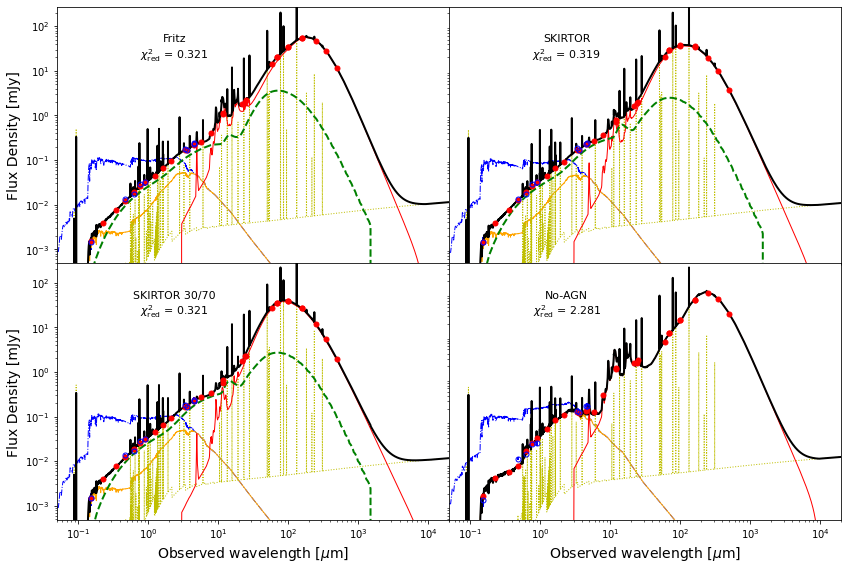

In [17]:
%matplotlib inline
Versions = ['FrIz_3Dic', 'SKIz_3Dic', 'SK3070_3Dic', 'SKIz0_3Dic']
FourSEDs(WorstGalaxy)
plt.show()

We implement a similar function to create the SEDs of all the galaxies analyzed with CIGALE. The data and the respective script is located in a complementary repository. 

##### Notebook info

In [18]:
%load_ext watermark
%watermark -a "Andres Ramos" -d -v -m
print('Specific Python packages')
%watermark -iv -w

Author: Andres Ramos

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 3.10.0-1160.25.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
numpy     : 1.19.5
json      : 2.0.9
re        : 2.2.1
sys       : 3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]
astropy   : 4.2
matplotlib: 3.2.2
autopep8  : 1.5.4
logging   : 0.5.1.2

Watermark: 2.1.0

